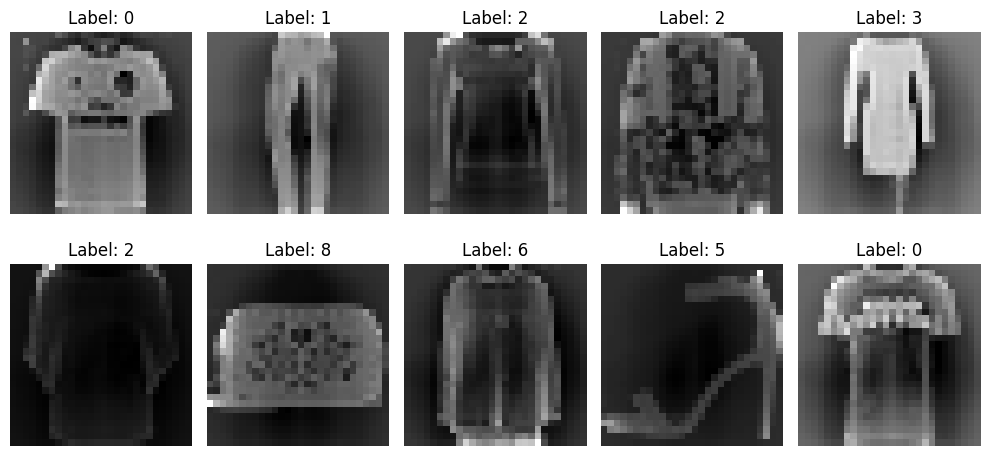

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
import warnings

# Load the dataset
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

# Take the first 8000 images from the train data and the first 2000 from the test data
train_data_subset = train_data.iloc[:8000]
test_data_subset = test_data.iloc[:2000]

# Separate features and labels
X_train = train_data_subset.drop('label', axis=1).values
y_train = train_data_subset['label'].values
X_test = test_data_subset.drop('label', axis=1).values
y_test = test_data_subset['label'].values

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Visualize 10 samples from the test dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {y_test[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Part 2: Train MLP Classifier with different activation functions
<!-- it takes approx 10 minutes -->

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

Training with activation: logistic
Training with activation: tanh
Training with activation: relu
Training with activation: identity


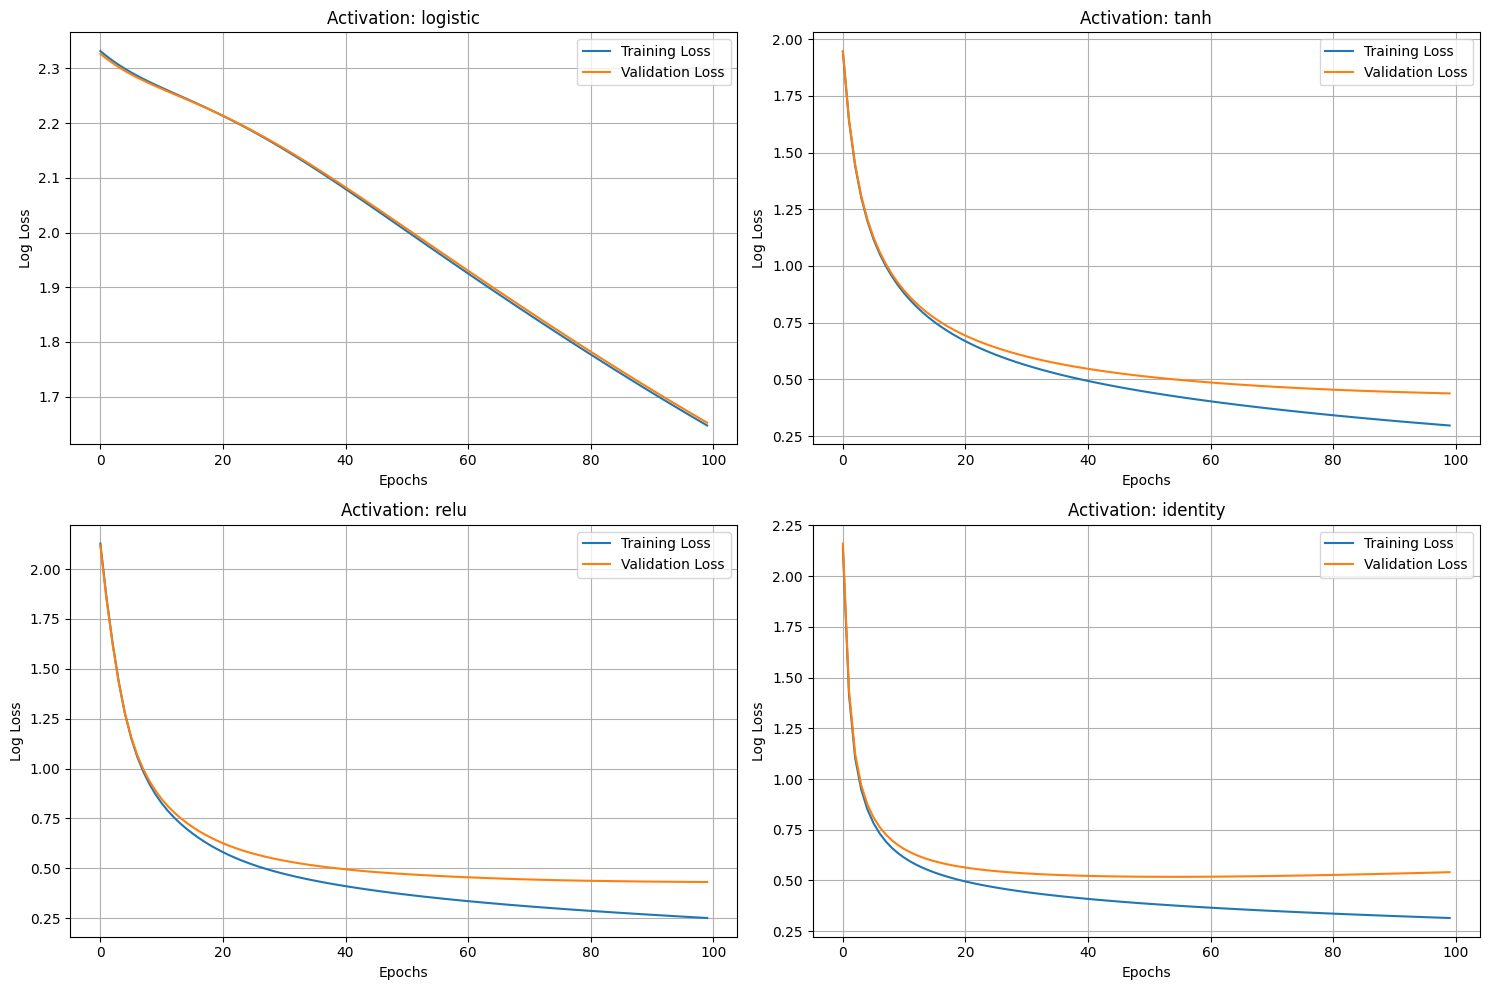

Test Accuracy with activation 'logistic': 0.5490
Test Accuracy with activation 'tanh': 0.8425
Test Accuracy with activation 'relu': 0.8375
Test Accuracy with activation 'identity': 0.8310

Best performing activation function on the test set: tanh


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import warnings
# Split training data into training and validation sets
X_train_full, X_val, y_train_full, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Parameters for MLP
hidden_layers = (128, 64, 32)
max_iter = 100
batch_size = 128
learning_rate = 2e-5
activations = ['logistic', 'tanh', 'relu', 'identity']
# activations = ['logistic']
# Dictionary to store training and validation losses for each activation function
loss_history = {activation: {'train_loss': [], 'val_loss': []} for activation in activations}

# Train the model for each activation function
for activation in activations:
    print(f"Training with activation: {activation}")
    
    # Initialize MLP classifier
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers,
                        activation=activation,
                        solver='adam',
                        batch_size=batch_size,
                        learning_rate_init=learning_rate,
                        max_iter=1,  # We will manually iterate to capture loss at each epoch
                        warm_start=True,  # So we can continue training without reinitializing
                        random_state=42,
                        verbose=False)
    
    # Manually fit the model and collect losses for each epoch
    for epoch in range(max_iter):
        # Train for one iteration (epoch)
        mlp.fit(X_train_full, y_train_full)
        
        # Compute training loss and validation loss
        train_pred_proba = mlp.predict_proba(X_train_full)
        val_pred_proba = mlp.predict_proba(X_val)
        
        train_loss = log_loss(y_train_full, train_pred_proba)
        val_loss = log_loss(y_val, val_pred_proba)
        
        # Store losses
        loss_history[activation]['train_loss'].append(train_loss)
        loss_history[activation]['val_loss'].append(val_loss)
        
        # print(f"Epoch {epoch + 1}/{max_iter}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting the training and validation loss curves
plt.figure(figsize=(15, 10))
for i, activation in enumerate(activations):
    plt.subplot(2, 2, i + 1)
    plt.plot(loss_history[activation]['train_loss'], label='Training Loss')
    plt.plot(loss_history[activation]['val_loss'], label='Validation Loss')
    plt.title(f'Activation: {activation}')
    plt.xlabel('Epochs')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Model performance on test set (for report)
test_scores = {}
for activation in activations:
    # Retrain model with full training data for best performance
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers,
                        activation=activation,
                        solver='adam',
                        batch_size=batch_size,
                        learning_rate_init=learning_rate,
                        max_iter=max_iter,
                        random_state=42)
    mlp.fit(X_train, y_train)
    test_score = mlp.score(X_test, y_test)
    test_scores[activation] = test_score
    print(f"Test Accuracy with activation '{activation}': {test_score:.4f}")

# Summarize the results
best_activation = max(test_scores, key=test_scores.get)
print(f"\nBest performing activation function on the test set: {best_activation}")


# Part 3: Grid search for best hyperparameters based on the best activation function

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer
import numpy as np

# Best activation function from part 2 (replace with your result)
best_activation = 'relu'  # Example: replace this with the best activation from part 2

# Define the parameter grid for hyperparameters
param_grid = {
    'solver': ['adam', 'sgd', 'lbfgs'],  # Solvers to try
    'learning_rate_init': [1e-3, 1e-4, 2e-5],  # Learning rates to try
    'batch_size': [32, 64, 128],  # Batch sizes to try (for 'sgd' solver)
    'hidden_layer_sizes': [(128, 64), (64, 32), (128, 64, 32)],  # Different layer sizes
    'alpha': [0.0001, 0.001, 0.01],  # Regularization strength
}

# Initialize the MLPClassifier with the best activation function
mlp = MLPClassifier(activation=best_activation, max_iter=1, warm_start=True, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")

# Train the model with the best found hyperparameters on the entire training set
best_mlp = grid_search.best_estimator_

# Evaluate the model on the test set
test_accuracy = best_mlp.score(X_test, y_test)
print(f"Test Accuracy with best hyperparameters: {test_accuracy:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate_init': 0.001, 'solver': 'adam'}
Best Cross-validation Accuracy: 0.8209
Test Accuracy with best hyperparameters: 0.8125


# Part 4: MLPRegressor for regeneration task

Iteration 1, loss = 6608.58549198
Iteration 1, loss = 6606.39377834
Epoch 1/100 completed
Iteration 1, loss = 6606.25546934
Iteration 1, loss = 6598.50127041
Iteration 1, loss = 6602.79239283
Iteration 1, loss = 6585.70338560
Iteration 1, loss = 6597.78704890
Iteration 1, loss = 6566.66205027
Iteration 1, loss = 6590.78122409
Iteration 1, loss = 6540.04941104
Iteration 1, loss = 6581.26184045
Iteration 1, loss = 6504.50659658
Iteration 1, loss = 6568.66426788
Iteration 1, loss = 6458.73387779
Iteration 1, loss = 6552.36043578
Iteration 1, loss = 6401.67014917
Iteration 1, loss = 6531.64342894
Iteration 1, loss = 6332.73088466
Iteration 1, loss = 6505.73141563
Iteration 1, loss = 6252.13688173
Iteration 1, loss = 6473.75617739
Iteration 1, loss = 6161.30660561
Epoch 11/100 completed
Iteration 1, loss = 6434.72359915
Iteration 1, loss = 6063.21279734
Iteration 1, loss = 6387.49954556
Iteration 1, loss = 5962.53516718
Iteration 1, loss = 6330.75288122
Iteration 1, loss = 5865.31601277
Ite

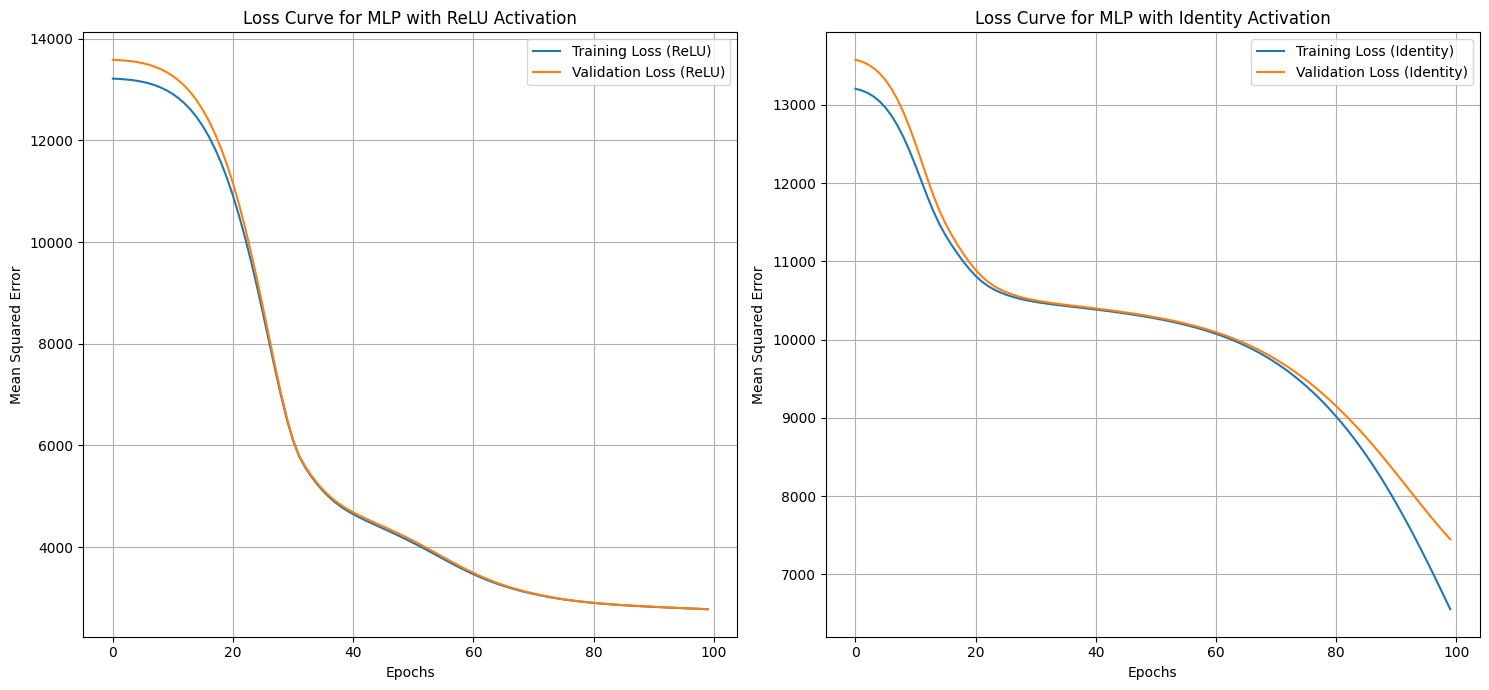

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (same as in the previous code)
train_data = pd.read_csv('fashion-mnist_train.csv')
test_data = pd.read_csv('fashion-mnist_test.csv')

# Take the first 8000 images from the train data and the first 2000 from the test data
train_data_subset = train_data.iloc[:8000]
test_data_subset = test_data.iloc[:2000]

# Separate features and labels
X_train = train_data_subset.drop('label', axis=1).values
y_train = X_train  # We want to regenerate the image, so target is the same as input
X_test = test_data_subset.drop('label', axis=1).values
y_test = X_test  # Same as input for the regeneration task

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the target for regression (flattened image)
X_train = X_train.reshape(X_train.shape[0], -1)  # Flattening images
X_test = X_test.reshape(X_test.shape[0], -1)  # Flattening images

# Neural network configuration [c, b, a, b, c] where c > b > a
hidden_layer_sizes = (128, 64, 32, 64, 128)

# Initialize two MLPRegressors with different activations
mlp_relu = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                        activation='relu',
                        solver='adam',
                        learning_rate_init=2e-5,
                        max_iter=1,
                        warm_start=True,  # So we can train one epoch at a time
                        random_state=42,
                        verbose=True)

mlp_identity = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                             activation='identity',
                             solver='adam',
                             learning_rate_init=2e-5,
                             max_iter=1,
                             warm_start=True,
                             random_state=42,
                             verbose=True)

# Initialize loss history dictionaries for both models
loss_history_relu = {'train_loss': [], 'val_loss': []}
loss_history_identity = {'train_loss': [], 'val_loss': []}

# Training loop for both networks
max_epochs = 100
for epoch in range(max_epochs):
    # Train with ReLU activation
    mlp_relu.fit(X_train, y_train)
    train_pred_relu = mlp_relu.predict(X_train)
    val_pred_relu = mlp_relu.predict(X_test)
    
    train_loss_relu = mean_squared_error(y_train, train_pred_relu)
    val_loss_relu = mean_squared_error(y_test, val_pred_relu)
    
    loss_history_relu['train_loss'].append(train_loss_relu)
    loss_history_relu['val_loss'].append(val_loss_relu)
    
    # Train with Identity activation
    mlp_identity.fit(X_train, y_train)
    train_pred_identity = mlp_identity.predict(X_train)
    val_pred_identity = mlp_identity.predict(X_test)
    
    train_loss_identity = mean_squared_error(y_train, train_pred_identity)
    val_loss_identity = mean_squared_error(y_test, val_pred_identity)
    
    loss_history_identity['train_loss'].append(train_loss_identity)
    loss_history_identity['val_loss'].append(val_loss_identity)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{max_epochs} completed")

# Plot the training and validation losses for both models
plt.figure(figsize=(15, 7))

# ReLU Activation
plt.subplot(1, 2, 1)
plt.plot(loss_history_relu['train_loss'], label='Training Loss (ReLU)')
plt.plot(loss_history_relu['val_loss'], label='Validation Loss (ReLU)')
plt.title("Loss Curve for MLP with ReLU Activation")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

# Identity Activation
plt.subplot(1, 2, 2)
plt.plot(loss_history_identity['train_loss'], label='Training Loss (Identity)')
plt.plot(loss_history_identity['val_loss'], label='Validation Loss (Identity)')
plt.title("Loss Curve for MLP with Identity Activation")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



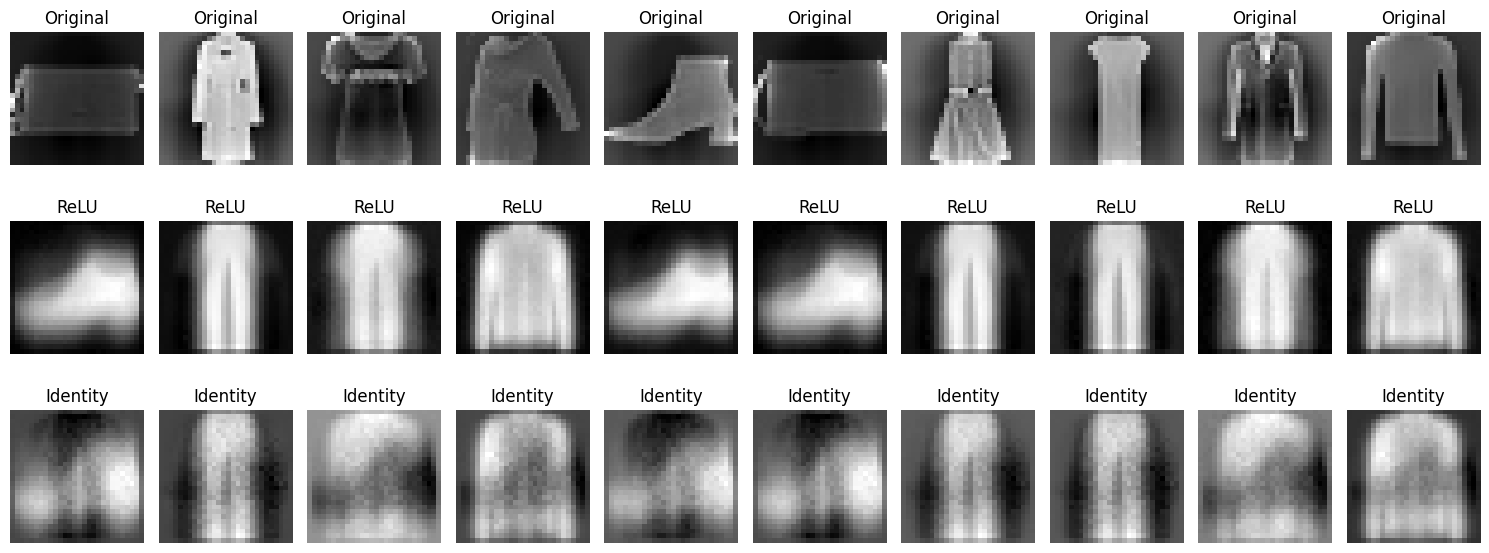

In [5]:
# Part (d): Visualize the generations for the 10 test samples
num_samples = 10
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

# Choose 10 test samples for visualization
sample_indices = np.random.choice(range(X_test.shape[0]), num_samples, replace=False)
original_images = X_test[sample_indices]
generated_images_relu = mlp_relu.predict(original_images)
generated_images_identity = mlp_identity.predict(original_images)

for i in range(num_samples):
    # Original Image
    axes[0, i].imshow(original_images[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')

    # ReLU Regeneration
    axes[1, i].imshow(generated_images_relu[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title("ReLU")
    axes[1, i].axis('off')

    # Identity Regeneration
    axes[2, i].imshow(generated_images_identity[i].reshape(28, 28), cmap='gray')
    axes[2, i].set_title("Identity")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Part 5: Extract features from MLPRegressor and train new classifiers

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Set the hidden layer size 'a' to extract the feature vectors
a = 32  # As used in [128, 64, 32, 64, 128]
n_classes = len(train_data['label'].unique())  # Number of classes in the dataset

# Function to extract features of size 'a' from the third layer (middle layer)
def extract_features(model, X):
    # Extract the outputs at the hidden layer 'a' (third layer) using model's partial_fit
    hidden_layer_output = np.tanh(X @ model.coefs_[0] + model.intercepts_[0])  # First layer
    hidden_layer_output = np.tanh(hidden_layer_output @ model.coefs_[1] + model.intercepts_[1])  # Second layer
    feature_vector = np.tanh(hidden_layer_output @ model.coefs_[2] + model.intercepts_[2])  # Third layer (size 'a')
    return feature_vector

# Extract feature vectors for both activations on train and test data
X_train_features_relu = extract_features(mlp_relu, X_train)
X_test_features_relu = extract_features(mlp_relu, X_test)
X_train_features_identity = extract_features(mlp_identity, X_train)
X_test_features_identity = extract_features(mlp_identity, X_test)

# Initialize two new MLP Classifiers with 2 layers, each of size 'a'
mlp_clf_relu = MLPClassifier(hidden_layer_sizes=(a, a),
                             activation='relu',
                             solver='adam',
                             learning_rate_init=2e-5,
                             max_iter=200,
                             random_state=42,
                             verbose=True)

mlp_clf_identity = MLPClassifier(hidden_layer_sizes=(a, a),
                                 activation='identity',
                                 solver='adam',
                                 learning_rate_init=2e-5,
                                 max_iter=200,
                                 random_state=42,
                                 verbose=True)

# Train classifiers on extracted features
mlp_clf_relu.fit(X_train_features_relu, train_data_subset['label'])
mlp_clf_identity.fit(X_train_features_identity, train_data_subset['label'])

# Make predictions and evaluate
y_pred_relu = mlp_clf_relu.predict(X_test_features_relu)
y_pred_identity = mlp_clf_identity.predict(X_test_features_identity)

# Report accuracy metrics
accuracy_relu = accuracy_score(test_data_subset['label'], y_pred_relu)
accuracy_identity = accuracy_score(test_data_subset['label'], y_pred_identity)

print("Accuracy for classifier trained on ReLU-extracted features:", accuracy_relu)
print("Classification Report for ReLU-extracted features:\n", classification_report(test_data_subset['label'], y_pred_relu))

print("Accuracy for classifier trained on Identity-extracted features:", accuracy_identity)
print("Classification Report for Identity-extracted features:\n", classification_report(test_data_subset['label'], y_pred_identity))


Iteration 1, loss = 2.42691142
Iteration 2, loss = 2.39954801
Iteration 3, loss = 2.37310577
Iteration 4, loss = 2.34745356
Iteration 5, loss = 2.32245063
Iteration 6, loss = 2.29780390
Iteration 7, loss = 2.27362632
Iteration 8, loss = 2.25004940
Iteration 9, loss = 2.22713102
Iteration 10, loss = 2.20474856
Iteration 11, loss = 2.18300724
Iteration 12, loss = 2.16168318
Iteration 13, loss = 2.14078602
Iteration 14, loss = 2.12023056
Iteration 15, loss = 2.09992136
Iteration 16, loss = 2.07984981
Iteration 17, loss = 2.05992016
Iteration 18, loss = 2.04019437
Iteration 19, loss = 2.02070631
Iteration 20, loss = 2.00146929
Iteration 21, loss = 1.98250776
Iteration 22, loss = 1.96378490
Iteration 23, loss = 1.94533047
Iteration 24, loss = 1.92705121
Iteration 25, loss = 1.90903402
Iteration 26, loss = 1.89117523
Iteration 27, loss = 1.87354527
Iteration 28, loss = 1.85609791
Iteration 29, loss = 1.83894800
Iteration 30, loss = 1.82203263
Iteration 31, loss = 1.80535590
Iteration 32, los

Contrast with Original MLP Classifier from Part 2
Input Dimensionality:

In part 2, the original MLP Classifier directly used the high-dimensional raw pixel data from the images as input, which contained thousands of features (one per pixel).
In this method, the input to the new classifiers is a much smaller feature vector of size a, extracted from the third hidden layer of the pre-trained MLPRegressors. This greatly reduces the dimensionality from the raw image data.
Feature Representation:

The original classifier learned the features from scratch using the raw pixel values. This means it had to learn to identify meaningful patterns across all pixels without any prior information.
The extracted features already capture significant information about the image, as the MLPRegressors trained for image regeneration learned compact, useful representations of each image. These representations, or feature vectors, are already optimized to retain essential characteristics of the image, making them more meaningful and easier for the classifier to process.
Training Complexity:

Training a classifier on high-dimensional data, as in part 2, is challenging due to the "curse of dimensionality." The model must learn useful patterns while filtering out noise from the thousands of pixel values.
By using the extracted feature vectors, the new classifiers in this part focus on fewer, more compact features. This reduces the training complexity and noise, making it easier for the model to converge to a good solution.
Generalization Capability:

The feature extraction process acts as a form of regularization. Because the extracted features are a condensed representation, the new classifiers benefit from a degree of generalization already present in these features, which the MLPRegressor learned while performing the regeneration task.
This method can generalize well, as it leverages learned representations that capture fundamental aspects of the images, rather than overfitting to specific pixel patterns in the raw data.
Reasons for Decent Classifier Performance
Efficient Encoding of Information: The extracted feature vector of size a from the hidden layer contains high-level patterns and structural information, representing each image in a more concise and informative way.
Transfer Learning Benefit: This approach resembles transfer learning, where the pre-trained network’s hidden layers serve as feature extractors. The classifiers trained on these features perform well because the network has already learned to capture the core attributes of the images during the regeneration task.
Reduced Dimensionality and Noise: The reduced dimensionality of the input makes the classifier less prone to overfitting and noise, as it relies on the distilled, meaningful features rather than raw pixel data.